In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
import matplotlib
matplotlib.rc('font', family='arial') 
import matplotlib.pyplot as plt
import numpy as np
from h5py import File
from fish.image.zds import ZDS
from fish.image.vol import InterpArray
from os.path import exists
import dask.array as da
from dask.distributed import Client
from scipy.ndimage.filters import median_filter
import zarr
from fish.util.distributed import get_downsampled_baseline
from os import remove
from glob import glob
import flika as flk
flk.start_flika()
from flika.window import Window as flw

def axs_format(ax, y_axis_pos='left'):
    ax.set_xlim(ax.lines[0].get_data()[0][[0,-1]])
    ax.yaxis.set_label_position(y_axis_pos)
    if y_axis_pos is 'left':
        ax.spines['right'].set_visible(False)
        ax.spines['top'].set_visible(False)
        ax.yaxis.tick_left()
    elif y_axis_pos is 'right':
        ax.spines['left'].set_visible(False)
        ax.spines['top'].set_visible(False)
        ax.yaxis.tick_right()
    
def get_klab_dataset(path):
    from glob import glob
    from fish.util.fileio import to_dask
    files = sorted(glob(path + 'TM*/*/*CM0*'))
    dsk = to_dask(files).squeeze().transpose(0,3,2,1)
    
    return dsk

def get_dsb(fname, chunksize, full_shape):
    fmt = fname.split('.')[-1]
    if fmt == 'h5':
        bl = da.from_array(File(fname, libver='latest', mode='r')['baseline'], chunks=chunksize).astype('float32')
        kf = File(fname, mode='r')['keyframes'][:]            
    elif fmt == 'zarr':
        zf = zarr.open(fname)
        kf = zf['keyframes'][:]
        bl = da.from_array(zf['baseline'])        
    else:
        raise ValueError(f'Format {fmt} not understood')
    dsb = InterpArray(kf, bl, full_shape=full_shape, interpolation_axis=0)
    return dsb

def save_dsb(fname, dsb):
    zr = zarr.open(fname)
    keyframes, baseline = dsb    
    zr.array('keyframes', keyframes)
    zr.array('baseline', baseline, chunks=(1, *baseline.shape[1:]))    
    
def init_baseline_file(fname, full_shape, dtype='float32'):
    root=zarr.open(fname, mode='w')
    root.create_dataset(name='baseline', shape=full_shape, dtype='float32', chunks=(1, *full_shape[1:]))
    root.create_dataset(name='keyframes', shape=full_shape[0], dtype='float32')
    
def mybl(v, window, percentile):
    from fish.image.vol import baseline
    return baseline(v, window, percentile, axis=0).astype('float32')

def mydff(v, window, percentile):
    return (v / mybl(v, window, percentile).clip(1,None)) - 1

def shift_yx(im, shifts, block_id):
    from scipy.ndimage.interpolation import shift
    t = block_id[0] 
    im_ = im
    if im.dtype == 'float16':
        im_ = im.astype('float32')
    return shift(im_, (0,0, *shifts[t]), order=1, cval=100).astype(im.dtype)

def save_errs(fname, factors, errs, init=False):    
    zf = zarr.open(fname, mode='w')
    for ind, factor in enumerate(factors):    
        zf.create_dataset(name=f'{factor}/mean', data=errs[ind][0]) 
        zf.create_dataset(name=f'{factor}/max', data=errs[ind][1])
        
def get_errs_from_file(fname):
    zf = zarr.open(fname)
    groups = (*zf,)
    dsets = ('mean', 'max')
    sample = zf[groups[0]][dsets[0]]
    err_ = np.zeros((len(groups), len(dsets), *sample.shape))
    for ind_o,g in enumerate(groups):
        for ind_i,d  in enumerate(dsets):
            err_[ind_o][ind_i] = zf[g][d][:]
    return err_

Starting flika
Starting flika inside IPython


In [2]:
which_dataset = 'keller'

In [3]:
if which_dataset == 'ahrens':
    base_dir = '/nrs/ahrens/Yu/SPIM/active_dataset/glia_neuron_imaging/20170221/fish4/20170221_4_3_gfaprgeco_hucgc_6dpf_wholebrain_faster_brighter_20170221_174442_noephys/'
    dset = ZDS(base_dir + 'raw/')
    data = dset.data
    exp_name = base_dir.split('/')[-2]
    reg_dir = f'/nrs/ahrens/davis/tmp/{exp_name}/'
    reg_path = reg_dir + 'regparams_affine.npy'
    
    fs_im = dset.metadata['volume_rate']
    shifts = -np.load(reg_path)[:,:-1,-1]
    
    window_seconds = 300
    window_frames = int(window_seconds * fs_im)
    tcrop = slice(window_frames//2, -window_frames//2)
    camera_baseline = 95
    percentile = 20
    

elif which_dataset == 'keller':
    data = get_klab_dataset('/nrs/keller/ForDavis/Dme_L1_57C10GCaMP641-54B03TDT_0_20130912_145536.corrected/SPM00/').transpose(0,1,3,2)
    data = data[750:]
    
    # 8 ms exposure * 40 planes
    fs_im = (.08 * data.shape[1])
    
    window_seconds = 90
    window_frames = int(window_seconds * fs_im)
    tcrop = slice(window_frames//2, -window_frames//2)
    camera_baseline = 0
    percentile = 20
    
    reg_dir = '/groups/ahrens/ahrenslab/davis/tmp/Dme_L1_57C10GCaMP641-54B03TDT_0/'
    if not exists(reg_dir):
        from os import makedirs
        makedirs(reg_dir)

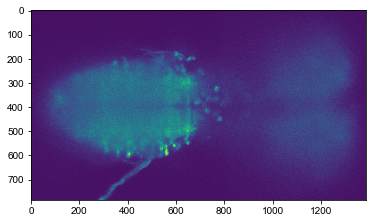

In [4]:
rois = dict()
rois['glia'] = slice(0,None), slice(16,17), slice(0, 1024), slice(20, None)
rois['neurons'] = slice(0,None), slice(16,17), slice(1024, None), slice(20,None)
rois['explant'] = slice(0,None), slice(20,21), slice(None), slice(None)

cell_group = 'explant'

roi = rois[cell_group]
err_path = reg_dir + f'err_{cell_group}.zarr'
crop=slice(None), slice(None), slice(10,-10), slice(10,-10)
sample = data[roi][-1].compute(scheduler='threads').squeeze()
plt.imshow(sample)

In [5]:
from fish.util.distributed import get_jobqueue_cluster
cluster = get_jobqueue_cluster()
client = Client(cluster)
client

/groups/ahrens/home/bennettd/miniconda/lib/python3.6/site-packages/dask_jobqueue/config.py:12: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  defaults = yaml.load(f)
/groups/ahrens/home/bennettd/miniconda/lib/python3.6/site-packages/distributed/deploy/local.py:138: UserWarning: diagnostics_port has been deprecated. Please use `dashboard_address=` instead
  "diagnostics_port has been deprecated. "


Client Scheduler: tcp://10.36.111.11:40514 Dashboard: http://10.36.111.11:8787/status,Cluster Workers: 0 Cores: 0 Memory: 0 B


In [6]:
if which_dataset == 'ahrens':
    data_filt = data[roi].astype('float32').map_blocks(lambda v: median_filter(v, size=(1,1,3,3)), dtype='float32')
    data_tx = data_filt.map_blocks(shift_yx, shifts[roi[0]], dtype='float32')
    rechunked = data_tx.rechunk((-1, 'auto', 'auto', 'auto')) 
    ds_factors = [12, 24, 36, 48]

elif which_dataset == 'keller':
    ds_factors = [12, 24, 36, 48]
    data_tx = data[roi].astype('float32')
    rechunked = data_tx.rechunk((-1, 'auto', 'auto','auto'))
    

In [7]:
make_baselines = True

bl_fnames = [reg_dir + f'baseline_ds{factor}.zarr' for factor in ds_factors]
for blf in bl_fnames:
    pass
    #assert exists(blf)

if make_baselines:
    dsbs_dsk = [get_downsampled_baseline(data_tx, factor=factor, perc=percentile, window=window_frames) for factor in ds_factors]
    cluster.start_workers(100)
    dsbs = client.compute(dsbs_dsk, sync=True)
    cluster.stop_all_jobs()
    for ind, factor in enumerate(ds_factors):
        fname = reg_dir + f'baseline_ds{factor}.zarr'        
        full_shape = (len(dsbs[ind][0]), *data.shape[1:])
        if not exists(fname):
            init_baseline_file(fname, full_shape=full_shape)

        fh = zarr.open(fname, mode='r+')
        fh['keyframes'] = dsbs[ind][0]
        fh['baseline'][roi] = dsbs[ind][1]
        del fh

In [8]:
# get the global mean of the whole experiment
cluster.start_workers(50)
mean_ts = data[roi].astype('float32').mean((1,2,3)).compute()
cluster.stop_all_jobs()

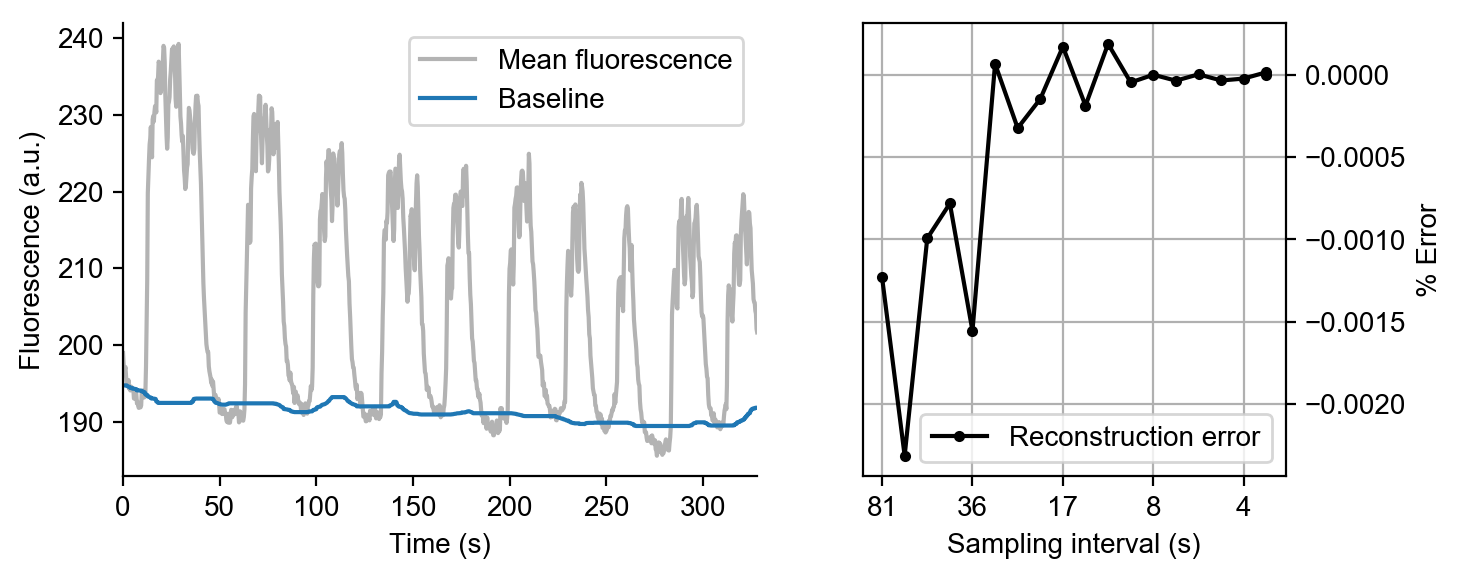

In [9]:
mean_bl = mybl(mean_ts, window=window_frames, percentile=percentile)
ds_subsamples = np.unique(np.geomspace(5, 100, 20).astype('int'))
kfs = [np.linspace(0, mean_bl.shape[0]-1, d).astype('int') for d in ds_subsamples]
intervals = np.array([np.gradient(k).mean().astype('int') for k in kfs])
lerped_bl = np.zeros([len(kfs), mean_bl.shape[0]])
for ind, kf in enumerate(kfs):
    lerped_bl[ind] = InterpArray(kf, mean_bl[kf], mean_bl.shape, 0)[:]

mse = ((mean_bl - lerped_bl)**2).mean(1)
pcte = ((mean_bl - lerped_bl) / mean_bl).mean(1)
x_im = np.arange(mean_ts.shape[0]) / fs_im
fig, axs = plt.subplots(figsize=(7.5, 3), dpi=200, ncols=2, gridspec_kw={'width_ratios':(1.5,1)})

axs[0].plot(x_im, mean_ts, color=(.7,.7,.7), label='Mean fluorescence')
axs[0].plot(x_im, mean_bl, label='Baseline')
axs[0].legend()
axs[0].set_xlabel('Time (s)')
axs[0].set_ylabel('Fluorescence (a.u.)')
axs_format(axs[0])
axs[1].plot((intervals/fs_im).astype('int').astype('str'), pcte,'.-',color='k', label='Reconstruction error')
axs[1].grid(True)
axs[1].set_xticks(axs[1].get_xticks()[::4])
axs[1].yaxis.tick_right()
axs[1].set_xlabel('Sampling interval (s)');
axs[1].legend()
axs[1].yaxis.set_label_position('right')
axs[1].set_ylabel('% Error')


fname = f'baseline_mean_{cell_group}.pdf'
plt.savefig(f'../../figures/ch5/{fname}')

In [10]:
compute_error = True

if compute_error:
    blds = [get_dsb(bl_fname, data.chunksize, data.shape)[roi][crop].astype('float32').squeeze() - camera_baseline for bl_fname in bl_fnames]
    blfull = rechunked[crop].map_blocks(lambda v: mybl(v, window=window_frames, percentile=percentile), dtype='float32') - camera_baseline
    
    cluster.start_workers(100)
    blfull_ = blfull.compute().squeeze()

    errs = np.zeros((len(bl_fnames),2, *blfull_.shape[1:]))

    for ind, bl_fname in enumerate(bl_fnames):
        blds_ = blds[ind].compute()
        err = (blds_[tcrop] / blfull_[tcrop]) - 1    
        errs[ind][0] = err.mean(0)
        errs[ind][1] = err.max(0)
        del err
        
    cluster.stop_all_jobs()
    save_errs(err_path, ds_factors, errs)
    
else:    
    errs = get_errs_from_file(err_path) 

distributed.utils_perf - WARNING - full garbage collections took 12% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 12% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took

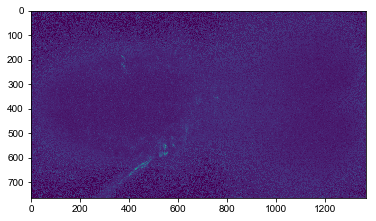

In [11]:
plt.imshow(errs[-1][1].clip(0,.1))

In [12]:
kfs = [zarr.open(fname,'r')['keyframes'][:] for fname in bl_fnames]
steps = [np.median(np.diff(kf_)) for kf_ in kfs]

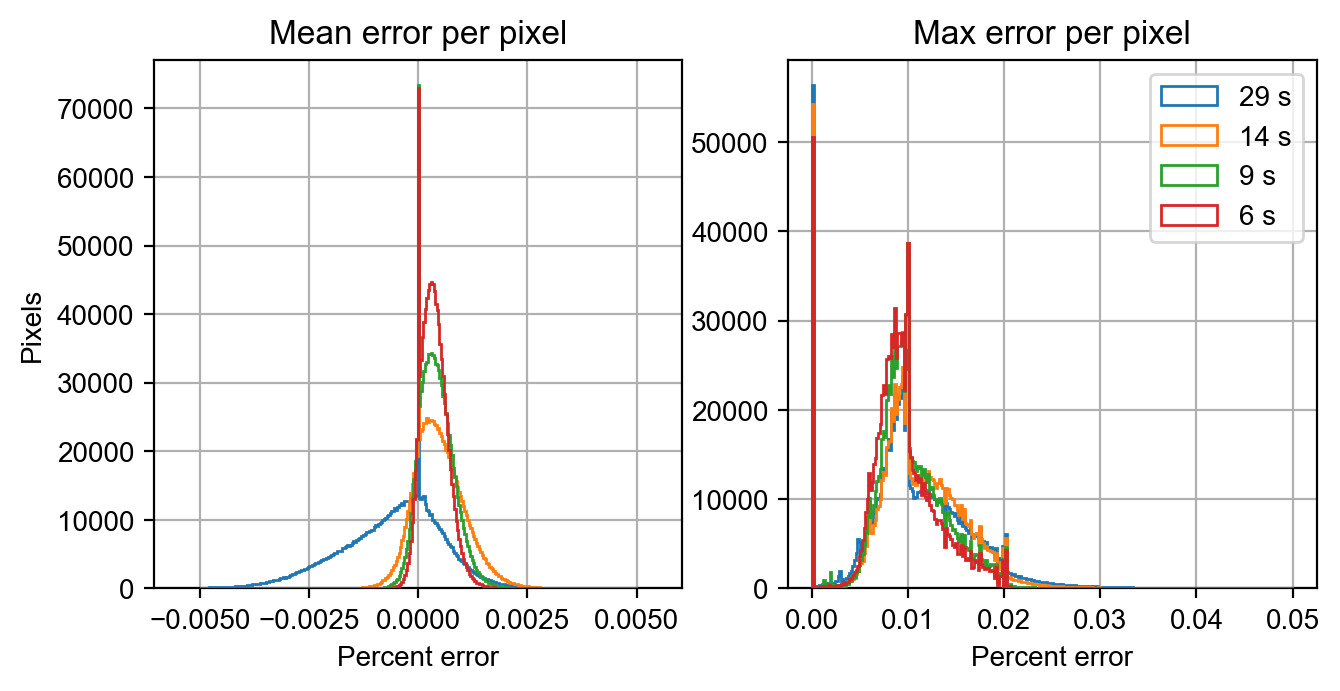

In [16]:
fig, axs = plt.subplots(ncols=2, figsize=(7.5 ,3.5), dpi=200)
nbins = 300
#bins_mean = np.linspace(errs[:,0].ravel().min(), errs[:,0].ravel().max(), nbins)
bins_mean = np.linspace(-.005, .005, nbins)
#bins_max = np.linspace(np.abs(errs[:,1]).ravel().min(), np.abs(errs[:,1]).ravel().max(), nbins)
bins_max = np.linspace(0, .05, nbins)
[axs[0].hist(err[0].ravel(), bins=bins_mean, histtype='step', zorder=5) for err in errs];
[axs[1].hist(np.abs(err[1]).ravel(), bins=bins_max, histtype='step', label=f'{int(steps[ind]/fs_im)} s', zorder=5) for ind, err in enumerate(errs)];
axs[0].set_xlim(np.abs(axs[0].get_xlim()) * np.array([-1.1,1.1]))
axs[0].title.set_text('Mean error per pixel')
axs[1].title.set_text('Max error per pixel')

axs[1].legend()
[ax.grid(True, zorder=0) for ax in axs]
axs[0].set_ylabel('Pixels')
[ax.set_xlabel('Percent error') for ax in axs]

fname = f'baseline_error_{cell_group}_plots.pdf'
plt.savefig(f'../../figures/ch5/{fname}')

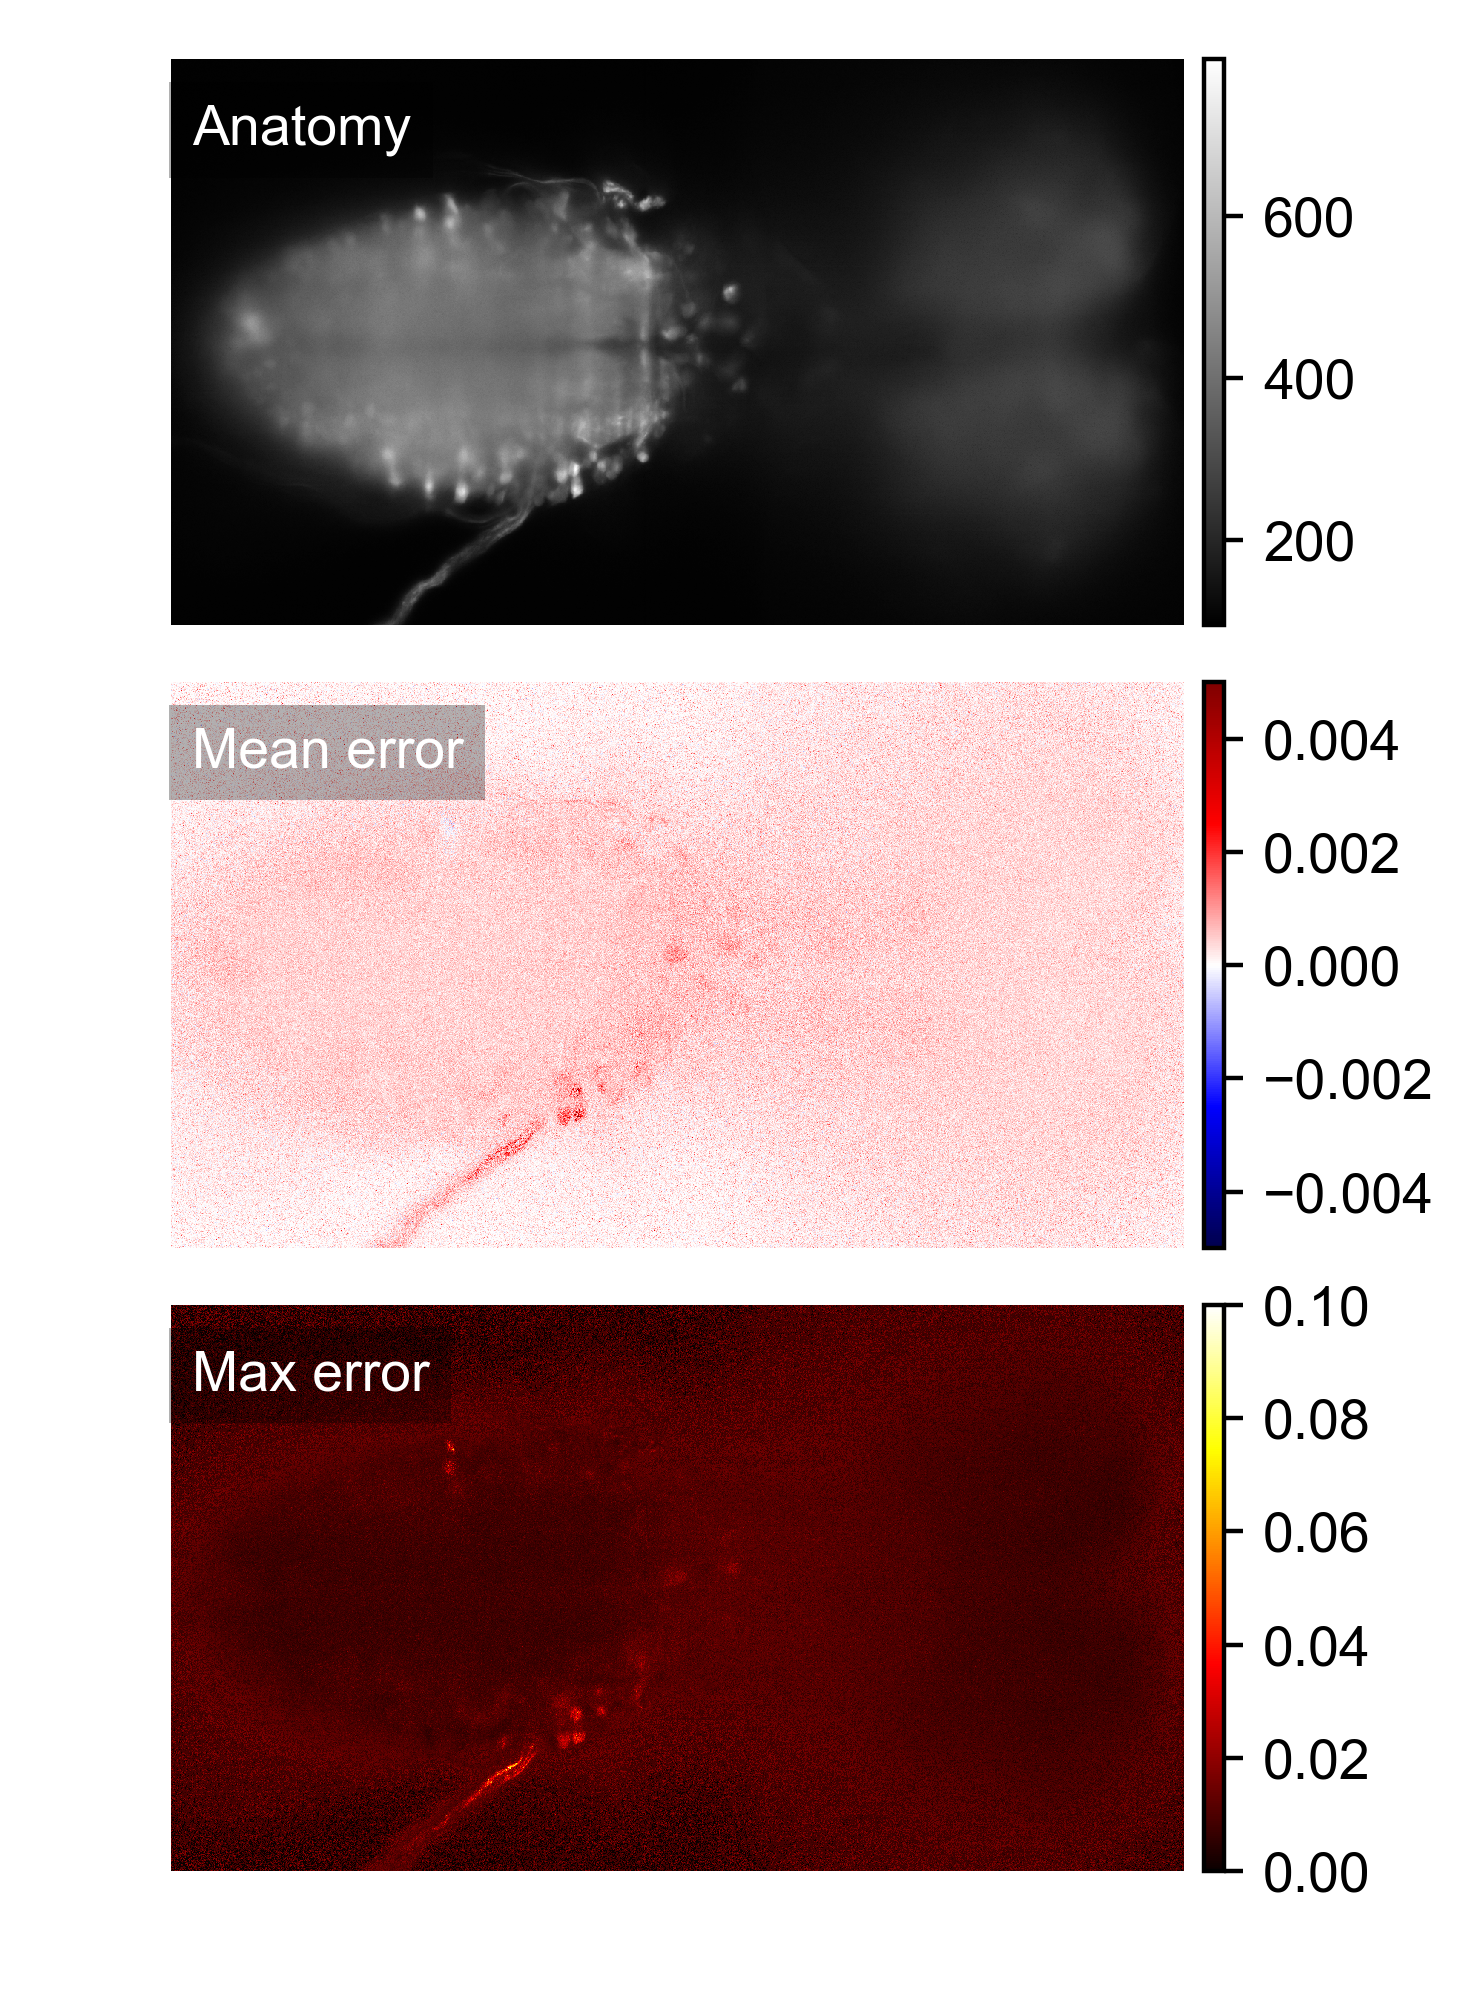

In [14]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

fig, axs = plt.subplots(figsize=(4,6),nrows=3, dpi=400)
labels = ['Anatomy', 'Mean error', 'Max error']
axs[0].imshow(blfull_[0], cmap='gray')
axs[1].imshow(errs[-1,0], cmap='seismic', clim=(-.005, .005))
axs[2].imshow(errs[-1,1], cmap='hot', clim=(0, .1))

labelpos = (.02, .85)

for ind, ax in enumerate(axs):    
    ax.axis('off')
    ax.text(*labelpos, labels[ind], transform=ax.transAxes, color='w', bbox=dict(facecolor = 'k', alpha=.3, linewidth=0))
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="2%", pad=0.05)
    plt.colorbar(ax.images[0], cax=cax)
    
plt.subplots_adjust(hspace=.1)
fname = f'baseline_error_{cell_group}_images.pdf'
plt.savefig(f'../../figures/ch5/{fname}')